# Deep Q Network with Cartpole

DQN was created by DeepMind researchers, achieving superhuman performance on many Atari games (https://deepmind.com/research/dqn/). What made the accomplishments of DQN even more impressive is that the DQN had nearly the same architecture and hyperparameter settings for each game (ie no game specific knowledge or set up) and the only inputs to the DQN were the screen pixels.

The main parts of the DQN are Q learning, the neural net, experience replay, target network updating, and data/environment pre-processing. For the neural net in this example, we replaced the Convolutional Neural Net (CNN) used in the original DQN with a 2 layer feed forward neural network (FFNN). We use the FFNN since CartPole doesn't give us image data. We'll use the CNN and data/environment pre-processing in the Pong DQN example


In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gym
import numpy as np

In [2]:
# check and use GPU if available if not use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Experience Replay Buffer

Q learning is an off-policy method. In off-policy methods we often save samples and then train on them. DQN has a memory buffer that stores state, action, reward, done condition, and next state samples. In the training loop, DQN will sample from this memory buffer and train on the saved samples. The replay buffer is essentially a queue that we randomly sample from. When the queue gets full we replace the first element of the queue. 

In [3]:
# replay buffer from and some code based on https://github.com/sfujim/TD3

# create replay buffer of tuples of (state, next_state, action, reward, done)
class ReplayBuffer():
    def __init__(self, max_size=1e6):
        self.storage = []
        self.max_size = max_size
        self.ptr = 0

    def add(self, data):
        if len(self.storage) == self.max_size:
            self.storage[int(self.ptr)] = data
            self.ptr = (self.ptr + 1) % self.max_size
        else:
            self.storage.append(data)

    def sample(self, batch_size):
        ind = np.random.randint(0, len(self.storage), size=batch_size)
        x, y, u, r, d = [], [], [], [], []

        for i in ind: 
            X, Y, U, R, D = self.storage[i]
            x.append(np.array(X, copy=False))
            y.append(np.array(Y, copy=False))
            u.append(np.array(U, copy=False))
            r.append(np.array(R, copy=False))
            d.append(np.array(D, copy=False))

        return np.array(x), np.array(y), np.array(u).reshape(-1,1), np.array(r).reshape(-1,1), np.array(d).reshape(-1,1)

### Feed Forward Neural Network

We use a simple FFNN for the function approximator. We create two linear, dense (fully-connected) layers and use a ReLU activation function. Note the input is the state size of the environment and the output is the action size of the environment. The outputs of the neural net are the estimated Q values based on the state input.

In [4]:
class FeedForwardNeuralNet(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super(FeedForwardNeuralNet, self).__init__()
        self.dense_layer_1 = nn.Linear(state_size, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, action_size)
    
    def forward(self, x):
        x = F.relu(self.dense_layer_1(x))
        x = F.relu(self.dense_layer_2(x))
        return self.output(x)

### CartPoleAgent Class

We create a CartPoleAgent class. The agent has a train network for learning a policy and a target network for performing target network updates. The agent has a select_action() function for sampling an action based on the epsilon-greedy method. The agent has a train() function, in which the agent samples from the replay buffer and updates the neural network parameters to improve its policy. The agent also has a update_target_network() function for updating the target network parameters with the training network parameters.

In [5]:
class CartPoleAgent():
    def __init__(self, state_size, action_size, hidden_size, learning_rate ):
        
        self.action_size = action_size
        self.train_net = FeedForwardNeuralNet(state_size, action_size, hidden_size).to(device)
        self.target_net = FeedForwardNeuralNet(state_size, action_size, hidden_size).to(device)
        self.target_net.load_state_dict(self.train_net.state_dict())
        self.optimizer = optim.Adam(self.train_net.parameters(), lr=learning_rate)

        
    def select_action(self, state, epsilon):
        # select action according to epsilon-greedy method
        if np.random.rand() <= epsilon:
            action = env.action_space.sample()
        else:
            # greedy action is the largest Q value from the train network based on the input
            with torch.no_grad():
                input_state = torch.FloatTensor(state).to(device)
                # feed input into the network and get the max action value
                action = self.train_net(input_state).max(0)[1].view(-1)
                action = int(action)
        return action

    
    def train(self, replay_buffer, batch_size, discount):
        # train the training network
        # sample a batch from the replay buffer
        x0, x1, a, r, d = replay_buffer.sample(batch_size)

        # turn batches into tensors and attack to GPU if available
        state_batch = torch.FloatTensor(x0).to(device)
        next_state_batch = torch.FloatTensor(x1).to(device)
        action_batch = torch.LongTensor(a).to(device)
        reward_batch = torch.FloatTensor(r).to(device)
        done_batch = torch.FloatTensor(1 - d).to(device)

        # get train net Q values
        train_q = self.train_net(state_batch).gather(1, action_batch)
        
        # get target net Qvalues
        with torch.no_grad():
            target_net_q = reward_batch + done_batch * discount * \
                     torch.max( self.target_net(next_state_batch).detach(), dim=1)[0].view(batch_size, -1)

        # create loss function
        loss_fn = nn.MSELoss()
        # get loss between train q values and target q values
        loss = loss_fn(train_q, target_net_q)
        # optimize the parameters with the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        # we return the loss so we can monitor loss and debug the network if necessary
        return loss.detach().cpu().numpy()
    
    
    def update_target_network(self, num_iter, update_every):
        # update target network every so often
        # hard target network update: updates target network fully with train network params
        if num_iter % update_every == 0:
            self.target_net.load_state_dict(self.train_net.state_dict())
            

### Target Network Updating

DQN has two networks: a train network and a target network. The target network provides the next-state Q values for the Q learning update. We use the next-state Q values to update the train network. Periodically we then update target network variables with the train network variables. Using a target network increases stability and convergence of the DQN.

### Hyperparameters

Hyperparameters are a variety of arguments that are usually tuned to help produce the best performing agents. Hyperparameter choice can be tricky as poor hyperparameter choice can prevent an agent from learning anything. The best choice depends on the algorithm and problem. Two basic methods that are used are random search, where you randomly pick hyperparameter values from a predefined range of values, and grid search where you systematically try all values and combinations based on a predefined grid of values.

In [6]:
# initialize environment
env = gym.make('CartPole-v0')
action_size = env.action_space.n
state_size = env.observation_space.shape[0]

# set seed
seed = 31
env.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# hyperparameters
episodes = 1000 # run agent for this many episodes
start_training_after = 100 # collect data for this many timesteps before training
hidden_size = 64 # number of units in NN hidden layers
learning_rate = 0.0005 # learning rate for optimizer
update_target_every_ts = 1000 # update target network after this many steps
batch_size = 64 # mini batch size we train network on
discount = 0.9 # gamma value

epsilon_start = 1.0 # epsilon start value
epsilon_min = 0.01  # epsilon end value
epsilon_decay_steps = episodes * .15 # decay epsilon over this many episodes
epsilon_step = (epsilon_start - epsilon_min)/(epsilon_decay_steps) # decrement epsilon by this amount every timestep

# create replay buffer
replay_size = 15000
replay_buffer = ReplayBuffer(max_size=replay_size)

# create cartpole agent
cartpole_agent = CartPoleAgent(state_size, action_size, hidden_size, learning_rate)
        

### The RL Training Loop

In the loop, we iterate through our episodes and then the timesteps within the episodes. We stop training the agent based on some stopping condition like a max episode value, a max timestep value, or the agent's performance reaches a certain level.

In each episode and at each timestep the agent selects an action, calls env.step(), and stores the sample in the replay buffer. The agent will also train the training neural network and periodically update the target network. When an episode is done the env is reset.

In [7]:
stats_rewards_list = [] # store stats for plotting in this
stats_every = 10 # print stats every this many episodes
total_reward = 0
timesteps = 0
episode_length = 0
epsilon = epsilon_start

for ep in range(episodes):
    state = env.reset()
    stats_loss = 0
    
    # stopping condition for training if agent reaches the amount of reward
    if len(stats_rewards_list) > stats_every and np.mean(stats_rewards_list[-stats_every:],axis=0)[1] > 190:
        print("Stopping at episode {} with average rewards of {} in last {} episodes".
            format(ep, np.mean(stats_rewards_list[-stats_every:],axis=0)[1], stats_every))
        break  
    
    # train in each episode until episode is done
    while True:
        timesteps += 1
        #env.render()
        # select an action from the agent's policy
        action = cartpole_agent.select_action(state, epsilon)
        # enter action into the env
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        episode_length += 1
        
        if done:
            next_state = np.zeros(state.shape)
            reward = -1
            # add experience to replay buffer
            replay_buffer.add((state, next_state, action, reward, done))
            
            stats_rewards_list.append((ep, total_reward, episode_length))
            total_reward = 0
            episode_length = 0
            
            epsilon -= epsilon_step
            if epsilon < epsilon_min:
                epsilon = epsilon_min
                
            if timesteps > start_training_after and ep % stats_every == 0:
                print('Episode: {}'.format(ep),
                    'Timestep: {}'.format(timesteps),
                    'Total reward: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[1]),
                    'Episode length: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[2]),
                    'Epsilon: {:.2f}'.format(epsilon),
                    'Loss: {:.3f}'.format(stats_loss))
                
            break
        else:
            # add experience to replay buffer
            replay_buffer.add((state, next_state, action, reward, done))
        
        state = next_state
        if timesteps > start_training_after:
            # train the agent
            stats_loss += cartpole_agent.train(replay_buffer, batch_size, discount)
            # update the target network every (if conditions are met in update_target_network)
            cartpole_agent.update_target_network(timesteps, update_target_every_ts)

Episode: 10 Timestep: 243 Total reward: 21.6 Episode length: 21.6 Epsilon: 0.93 Loss: 6.357
Episode: 20 Timestep: 446 Total reward: 20.3 Episode length: 20.3 Epsilon: 0.86 Loss: 1.924
Episode: 30 Timestep: 768 Total reward: 32.2 Episode length: 32.2 Epsilon: 0.80 Loss: 4.944
Episode: 40 Timestep: 983 Total reward: 21.5 Episode length: 21.5 Epsilon: 0.73 Loss: 2.929
Episode: 50 Timestep: 1257 Total reward: 27.4 Episode length: 27.4 Epsilon: 0.66 Loss: 2.241
Episode: 60 Timestep: 1647 Total reward: 39.0 Episode length: 39.0 Epsilon: 0.60 Loss: 12.891
Episode: 70 Timestep: 2032 Total reward: 38.5 Episode length: 38.5 Epsilon: 0.53 Loss: 3.642
Episode: 80 Timestep: 2642 Total reward: 61.0 Episode length: 61.0 Epsilon: 0.47 Loss: 12.906
Episode: 90 Timestep: 3375 Total reward: 73.3 Episode length: 73.3 Epsilon: 0.40 Loss: 12.882
Episode: 100 Timestep: 4391 Total reward: 101.6 Episode length: 101.6 Epsilon: 0.33 Loss: 3.846
Episode: 110 Timestep: 5894 Total reward: 150.3 Episode length: 150.

Text(0, 0.5, 'Episode Reward')

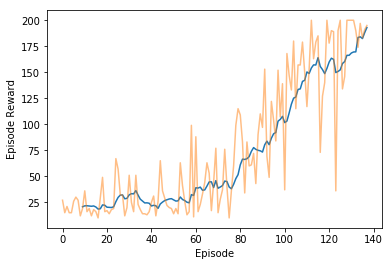

In [8]:
# plot stats
def get_running_stat(stat, stat_len):
    cum_sum = np.cumsum(np.insert(stat, 0, 0)) 
    return (cum_sum[stat_len:] - cum_sum[:-stat_len]) / stat_len

episode, r, l = np.array(stats_rewards_list).T
cum_r = get_running_stat(r, 10)
cum_l = get_running_stat(l, 10)

# plot rewards
plt.plot(episode[-len(cum_r):], cum_r)
plt.plot(episode, r, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Reward')

Text(0, 0.5, 'Episode Length')

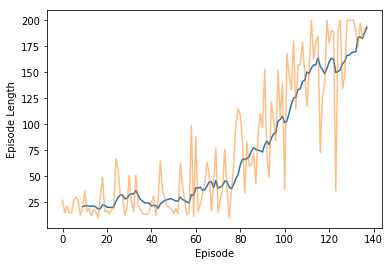

In [9]:
# plot episode lengths
plt.plot(episode[-len(cum_l):], cum_l)
plt.plot(episode, l, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Length')